In [1]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_plotly
%run -m ipy_seaborn
%matplotlib inline
from musc_genomics import data
from musc_genomics.common import SEED
from musc_genomics.data_modeling import modeling, features, prepared
from ml.model import models as ml_model
from ml.model import summaries as ml_precis
pd.set_option('max_info_rows', 10000)
pd.set_option('max_info_columns', 10000)

2016-08-11 10:16:41,601:INFO:requests.packages.urllib3.connectionpool: Starting new HTTPS connection (1): api.plot.ly


In [2]:
target_drugs = ['Navitoclax', 'Nutlin', 'AG-014699', 'PD-0332991', 'PLX4720', 'SB590885']
d, na_summary, fill_summary, imp_summary = prepared.get_modeling_data_01('maximal_02', impute_response=False)

2016-08-11 10:16:43,404:DEBUG:research.project.manager: Loading saved data from location "/Users/eczech/data/research/musc_genomics/features/encode_maximal_02.pkl"


In [3]:
d = features.filter_responses(d, target_drugs)
d.filter(regex='RES:').info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 583 entries, (22RV1, PRAD, prostate, carcinoma) to (ZR7530, BRCA, breast, carcinoma)
Data columns (total 6 columns):
RES:ERK MAPK signaling:BRAF:PLX4720                         561 non-null float64
RES:ERK MAPK signaling:BRAF:SB590885                        481 non-null float64
RES:Genome integrity:PARP1, PARP2:AG-014699                 543 non-null float64
RES:apoptosis regulation:BCL-2, BCL-XL, BCL-W:Navitoclax    494 non-null float64
RES:cell cycle:CDK4, CDK6:PD-0332991                        476 non-null float64
RES:p53 pathway:MDM2:Nutlin-3a (-)                          494 non-null float64
dtypes: float64(6)
memory usage: 31.9+ KB


In [4]:
#imp_summary[d.filter(regex='RES:').columns]

In [4]:
mask = d.filter(regex='RES:').isnull().apply(np.any, axis=1)
n = len(d)
d = d[~mask.values]
print('Removing {} records of {} due to missing response'.format(n - len(d), n))
d.filter(regex='RES:').info()

Removing 125 records of 583 due to missing response
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 458 entries, (22RV1, PRAD, prostate, carcinoma) to (ZR7530, BRCA, breast, carcinoma)
Data columns (total 6 columns):
RES:ERK MAPK signaling:BRAF:PLX4720                         458 non-null float64
RES:ERK MAPK signaling:BRAF:SB590885                        458 non-null float64
RES:Genome integrity:PARP1, PARP2:AG-014699                 458 non-null float64
RES:apoptosis regulation:BCL-2, BCL-XL, BCL-W:Navitoclax    458 non-null float64
RES:cell cycle:CDK4, CDK6:PD-0332991                        458 non-null float64
RES:p53 pathway:MDM2:Nutlin-3a (-)                          458 non-null float64
dtypes: float64(6)
memory usage: 25.0+ KB


In [5]:
responses = d.filter(regex='RES:').columns.tolist()
X, Y = d.drop(responses, axis=1), d[responses]

In [6]:
d.filter(regex='^CL:').std().describe()

count    50.000000
mean      0.174074
std       0.133474
min       0.000000
25%       0.069696
50%       0.122814
75%       0.227417
max       0.499166
dtype: float64

In [9]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.cross_validation import KFold
from xgboost import XGBRegressor

cv = KFold(len(Y), 10, shuffle=True, random_state=SEED)

clf_rf = Pipeline([
    ('filter', VarianceThreshold(threshold=.05)),
    ('clf', RandomForestRegressor(random_state=SEED))
])
clf_etr = Pipeline([
    ('filter', VarianceThreshold(threshold=.05)),
    ('clf', ExtraTreesRegressor(random_state=SEED))
])
clf_lasso = Pipeline([
    ('filter', VarianceThreshold(threshold=.05)),
    ('scale', StandardScaler()),
    ('clf', MultiTaskLassoCV(random_state=SEED, n_jobs=3, cv=3, n_alphas=25))
])

clfs = {
    'rf': clf_rf,
    'etr': clf_etr,
    'lasso': clf_lasso,
    'baseline': DummyRegressor()
}

n_jobs = 1 # Do not change this, change n_jobs in models instead
cv_res, refit_res = ml_model.run_models(
    X, Y, clfs, cv, 'regressor', 
    keep_training_data=False, par_n_jobs=n_jobs, 
    refit=True
)

2016-08-11 10:25:15,672:INFO:ml.model.log: Running model baseline (DummyRegressor) on fold 1 ==> dim(train) = (412, 89039), dim(test) = (46, 89039)
2016-08-11 10:25:15,681:INFO:ml.model.log: Running model etr (Pipeline) on fold 1 ==> dim(train) = (412, 89039), dim(test) = (46, 89039)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2016-08-11 10:25:55,077:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(train) = (412, 89039), dim(test) = (46, 89039)
2016-08-11 10:28:01,113:INFO:ml.model.log: Running model rf (Pipeline) on fold 1 ==> dim(train) = (412, 89039), dim(test) = (46, 89039)
2016-08-11 10:29:09,533:INFO:ml.model.log: Running model baseline (DummyRegressor) on fold 2 ==> dim(train) = (412, 89039), dim(test) = (46, 89039)
2016-08-11 10:29:09,540:INFO:ml.model.log: Running model etr (Pipeline) on fold 2 ==> dim(train) = (412, 89039), dim(test) = (46, 89039)
2016-08-11 10:29:46,764:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(train) = (412, 89039), dim(test) = (46, 89039)
2016-08-11 10:32:36,222:INFO:ml.model.log: Running model rf (Pipeline) on fold 2 ==> dim(train) = (412, 89039), dim(test) = (46, 89039)
2016-08-11 10:33:50,337:INFO:ml.model.log: Running model baseline (DummyRegressor) on fold 3 ==> dim(train) = (412, 89039), dim(test) = (46, 89039)
2016-08-11 10:33:

In [10]:
data.save('modeling/cosmic6', 'multi_task_models', (cv_res, refit_res))
#(cv_res, refit_res) = data.load('modeling/cosmic6', 'multi_task_models')

2016-08-11 11:48:37,475:DEBUG:research.project.manager: Saving data to location "/Users/eczech/data/research/musc_genomics/modeling/cosmic6/multi_task_models.pkl"


'/Users/eczech/data/research/musc_genomics/modeling/cosmic6/multi_task_models.pkl'

In [23]:
X.shape

(458, 89039)

In [29]:
from ml.model import importances
from numpy import linalg as LA

def feat_imp_pipeline(clf):
    cols = X.columns
    assert cols.shape == clf.named_steps['filter'].get_support().shape
    cols = cols[clf.named_steps['filter'].get_support()]
    
    if isinstance(clf.named_steps['clf'], MultiTaskLassoCV):
        res = pd.DataFrame(clf.named_steps['clf'].coef_, columns=cols).apply(LA.norm)
    else:
        res = importances.get_regressor_fi(clf, cols)
    return res

feat_imp_calc = {
    'etr': feat_imp_pipeline,
    'rf': feat_imp_pipeline,
    'lasso': feat_imp_pipeline
}
feat_imp = ml_model.summarize_importances([refit_res], feat_imp_calc=feat_imp_calc)
ml_precis.plot_feature_importance([refit_res], limit=35, feat_imp_calc=feat_imp_calc)

In [30]:
data.save('modeling/cosmic6', 'multi_task_feat_imp', feat_imp)

2016-08-11 12:14:03,431:DEBUG:research.project.manager: Saving data to location "/Users/eczech/data/research/musc_genomics/modeling/cosmic6/multi_task_feat_imp.pkl"


'/Users/eczech/data/research/musc_genomics/modeling/cosmic6/multi_task_feat_imp.pkl'

In [33]:
feat_imp.head()

FEATURE,CN:A1BG,CN:A1BG-AS1,CN:A1CF,CN:A2M,CN:A2ML1,CN:A4GALT,CN:A4GNT,CN:AAAS,CN:AACS,CN:AACSP1,...,CL:CANCER_TYPE:solid,CL:HISTOLOGY:carcinoma,CL:HISTOLOGY:glioma,CL:HISTOLOGY:haematopoietic_neoplasm,CL:HISTOLOGY:lymphoid_neoplasm,CL:GENDER:female,CL:GENDER:male,CL:GENDER:unknown,model_name,fold_id
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,etr,0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,lasso,0
2,0.0,0.0,0.000037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rf,0


In [47]:
feat_imp.set_index(['model_name', 'fold_id']).stack().rename('IMP').reset_index()\
    .assign(RANK=lambda x: x['IMP'].rank(ascending=False))\
    .loc[lambda x: x['FEATURE'].str.contains('^CL:|TP53')]\
    .loc[lambda x: x['IMP'] > 0]\
    .sort_values('RANK')

,model_name,fold_id,FEATURE,IMP,RANK
73676,lasso,0,MU:TYP:TP53:missense_mutation,0.035402,67.0
36814,etr,0,MU:TYP:TP53:missense_mutation,0.000732,663.0
34639,etr,0,GE:TP53TG1,0.000662,728.0
36852,etr,0,CL:PRIMARY_SITE:lung,0.000404,1112.0
108361,rf,0,GE:TP53INP2,0.000268,1509.0
110578,rf,0,CL:CANCER_TYPE:solid,0.000171,2139.0
36496,etr,0,MU:IMP:TP53:unknown,0.000158,2248.0
18242,etr,0,CN:TP53INP2,0.000152,2321.0
18238,etr,0,CN:TP53I11,0.000107,2944.0
34640,etr,0,GE:TP53TG5,0.000034,5289.0


In [16]:
d_pred = ml_model.summarize_predictions(cv_res, y_names=Y.columns.tolist())
d_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1832 entries, 0 to 44
Data columns (total 14 columns):
y_pred_RES:ERK MAPK signaling:BRAF:PLX4720                         1832 non-null float64
y_true_RES:ERK MAPK signaling:BRAF:PLX4720                         1832 non-null float64
y_pred_RES:ERK MAPK signaling:BRAF:SB590885                        1832 non-null float64
y_true_RES:ERK MAPK signaling:BRAF:SB590885                        1832 non-null float64
y_pred_RES:Genome integrity:PARP1, PARP2:AG-014699                 1832 non-null float64
y_true_RES:Genome integrity:PARP1, PARP2:AG-014699                 1832 non-null float64
y_pred_RES:apoptosis regulation:BCL-2, BCL-XL, BCL-W:Navitoclax    1832 non-null float64
y_true_RES:apoptosis regulation:BCL-2, BCL-XL, BCL-W:Navitoclax    1832 non-null float64
y_pred_RES:cell cycle:CDK4, CDK6:PD-0332991                        1832 non-null float64
y_true_RES:cell cycle:CDK4, CDK6:PD-0332991                        1832 non-null float64
y_pre

In [17]:
d_pp = d_pred.assign(row_id=np.arange(len(d_pred)))\
    .set_index(['model_name', 'fold_id', 'row_id']).rename_axis('drug', axis=1)\
    .stack(dropna=False).rename('value').reset_index()\
    .assign(type=lambda x: x['drug'].apply(lambda v: '_'.join(v.split('_')[:2])))\
    .assign(drug_name=lambda x: x['drug'].str.split(':').str[-1])\
    .drop('drug', axis=1)
    
idx_cols = np.setdiff1d(d_pp.columns.tolist(), ['value'])
d_pp = d_pp.set_index(list(idx_cols))['value'].unstack('type').reset_index()
d_pp.columns.name = None
d_pp.head()

,drug_name,fold_id,model_name,row_id,y_pred,y_true
0,AG-014699,1,baseline,0,3.424216,2.813023
1,AG-014699,1,baseline,1,3.424216,4.806778
2,AG-014699,1,baseline,2,3.424216,4.264925
3,AG-014699,1,baseline,3,3.424216,3.552252
4,AG-014699,1,baseline,4,3.424216,2.323225


In [18]:
data.save('modeling/cosmic6', 'multi_task_pred', d_pp)

2016-08-11 11:50:39,642:DEBUG:research.project.manager: Saving data to location "/Users/eczech/data/research/musc_genomics/modeling/cosmic6/multi_task_pred.pkl"


'/Users/eczech/data/research/musc_genomics/modeling/cosmic6/multi_task_pred.pkl'

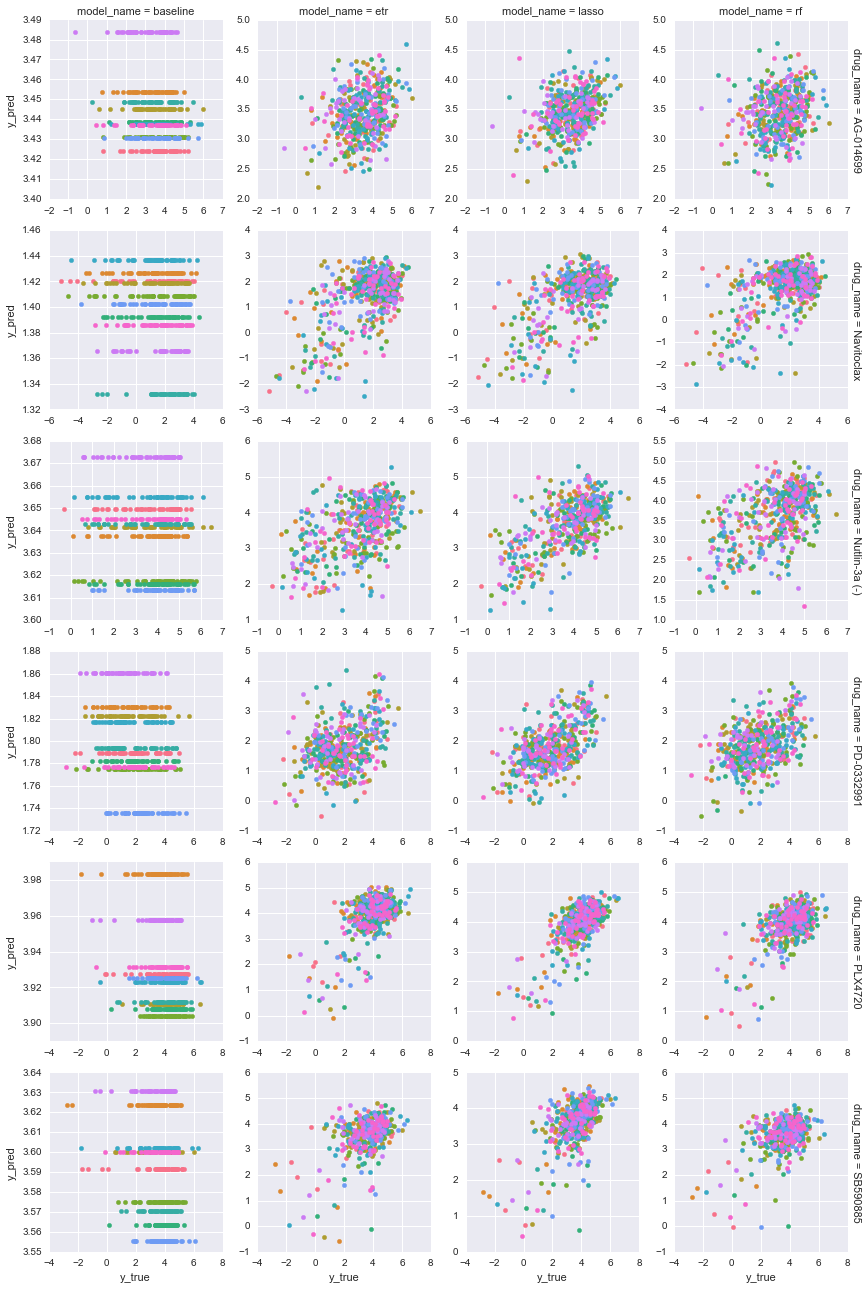

In [19]:
g = sns.FacetGrid(
    d_pp, row='drug_name', col='model_name', hue='fold_id', 
    margin_titles=True, sharex=False, sharey=False
)
g.map(plt.scatter, 'y_true', 'y_pred')

In [20]:
from sklearn.metrics import r2_score
def get_score(g):
    #return r2_score(g['y_true'], g['y_pred'])
    return g['y_true'].corr(g['y_pred'])**2
d_perf = d_pp.groupby(['model_name', 'drug_name', 'fold_id']).apply(get_score)\
    .rename('score').reset_index()
d_perf.head()

,model_name,drug_name,fold_id,score
0,baseline,AG-014699,1,2.008406e-31
1,baseline,AG-014699,2,4.067348e-32
2,baseline,AG-014699,3,2.089303e-31
3,baseline,AG-014699,4,8.261010e-32
4,baseline,AG-014699,5,5.716480e-31


In [21]:
data.save('modeling/cosmic6', 'multi_task_perf', d_perf)

2016-08-11 11:51:35,067:DEBUG:research.project.manager: Saving data to location "/Users/eczech/data/research/musc_genomics/modeling/cosmic6/multi_task_perf.pkl"


'/Users/eczech/data/research/musc_genomics/modeling/cosmic6/multi_task_perf.pkl'

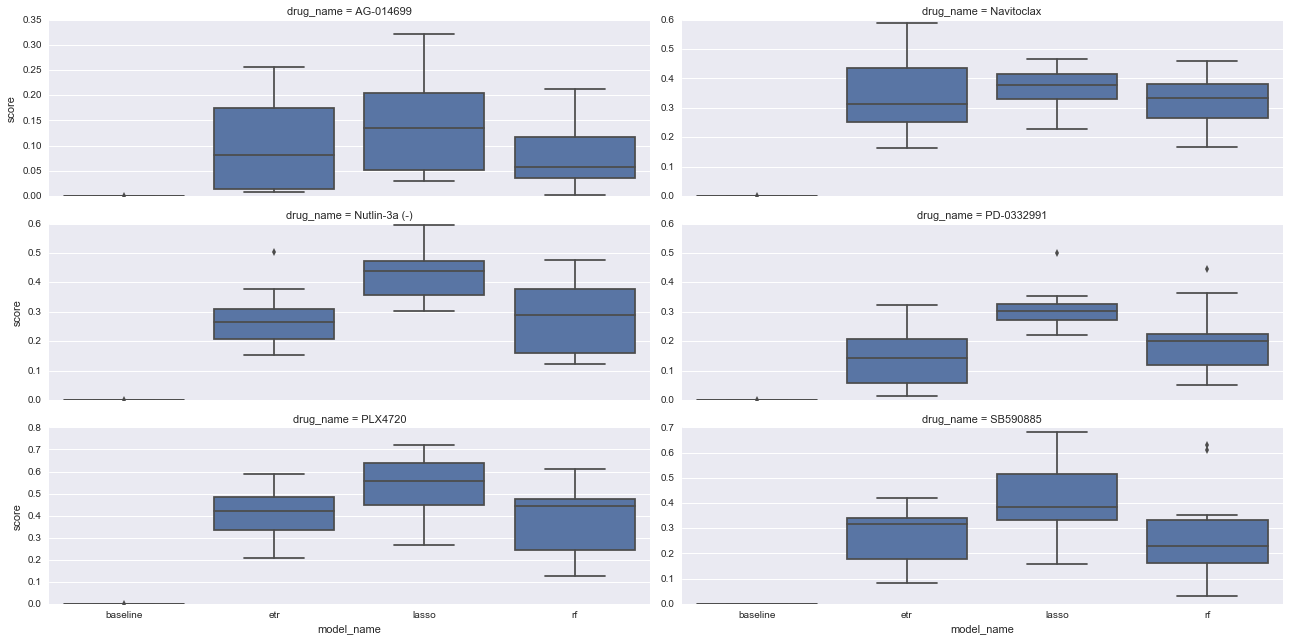

In [22]:
plt.figure(figsize=(8,12))
sns.FacetGrid(d_perf, col='drug_name', size=3, aspect=3, sharey=False, col_wrap=2)\
    .map(sns.boxplot, 'model_name', 'score')